In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) LOAD & PREPROCESS DATA
# ---------------------------------------------

df = pd.read_csv("../data/msk_2024_mutations_filtered.csv")
df = df.iloc[:, [0, 3] + list(range(266, len(df.columns)))]
df

,Patient,highest_stage_recorded,PIK3CA_Missense_Mutation_SNP_chr3,TP53_Missense_Mutation_SNP_chr17,GATA3_Frame_Shift_Ins_INS_chr10,ESR1_Missense_Mutation_SNP_chr6,ALK_Missense_Mutation_SNP_chr2,RNF43_Missense_Mutation_SNP_chr17,TSHR_Missense_Mutation_SNP_chr14,TP53_Nonsense_Mutation_SNP_chr17,...,DROSHA_Frame_Shift_Ins_INS_chr5,POLE_In_Frame_Del_DEL_chr12,ELF3_Splice_Site_SNP_chr1,HLA-B_Splice_Site_SNP_chr6,FANCA_Splice_Site_SNP_chr16,MDC1_In_Frame_Del_DEL_chr6,PREX2_Splice_Site_SNP_chr8,KMT2B_Splice_Site_SNP_chr19,NSD2_Frame_Shift_Ins_INS_chr4,MED12_Missense_Mutation_DNP_chr23
0,P-0000015,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,P-0000036,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,P-0000041,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,P-0000066,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,P-0000058,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,P-0087885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23537,P-0089690,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23538,P-0089687,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
23539,P-0089676,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:

# Extract patient IDs
patient_ids = df['Patient'].values

# Get binary mutation features; convert to float32 for PyTorch
X = df.drop(columns='Patient').values.astype(np.float32)

# Get highest stage recorded; convert to float32 for PyTorch
y_true = df['highest_stage_recorded'].values.astype(np.float32)

In [4]:

num_positives = np.sum(X, axis=0)
num_negatives = X.shape[0] - num_positives
pos_weight = num_negatives / (num_positives + 1e-6)  # Avoid division by zero
print(pos_weight)
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

[1.5414013e+00 5.7336955e+00 1.8125448e+00 ... 2.1390908e+03 2.3530999e+03
 2.1390908e+03]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    """
    A simple Transformer-like attention block with:
    1) Multi-head Self-Attention
    2) Residual Connection + LayerNorm
    3) Feed-forward Subnetwork
    4) Another Residual Connection + LayerNorm
    """
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super().__init__()
        
        # Multi-Head Self-Attention
        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True  # so input is [batch, seq_len, embed_dim]
        )
        
        # Layer Norms
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        # Feed-forward sublayer
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )
        
    def forward(self, x):
        """
        x shape: [batch_size, seq_len, embed_dim]
        """
        # 1) Multi-head self-attention
        attn_output, _ = self.mha(x, x, x)  # queries=keys=values=x
        
        # 2) Residual + LayerNorm
        x = self.ln1(x + attn_output)
        
        # 3) Feed-forward
        ff_output = self.ff(x)
        
        # 4) Residual + LayerNorm
        out = self.ln2(x + ff_output)
        return out
    

In [6]:
class AttentionAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32, num_heads=1, dropout=0.1):
        """
        Args:
            input_dim   : Dimensionality of the input features.
            hidden_dim  : Dimensionality inside the encoder/decoder prior to the latent space.
            latent_dim  : Bottleneck (latent) dimensionality.
            num_heads   : Number of attention heads in the self-attention block.
            dropout     : Dropout rate for the attention mechanism.
        """
        super().__init__()
        
        # -- ENCODER --
        self.encoder_fc1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_attn = AttentionBlock(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout)
        self.encoder_fc2 = nn.Linear(hidden_dim, latent_dim)
        
        # -- DECODER --
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_attn = AttentionBlock(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)
        
        # -- Classifier --
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 1)  # 1 logit for binary classification
        )
        
    def encode(self, x):
        """
        Encodes input x into a latent representation z.
        x shape: [batch_size, input_dim]
        """
        x = self.encoder_fc1(x)  # [batch_size, hidden_dim]
        x = F.relu(x)
        
        # For multi-head attention, we typically have a sequence dimension
        # but here we have only 1 "token" per sample. We'll treat each sample
        # as [batch_size, seq_len=1, hidden_dim].
        x = x.unsqueeze(1)      # [batch_size, 1, hidden_dim]
        x = self.encoder_attn(x)   # [batch_size, 1, hidden_dim]
        x = x.squeeze(1)       # [batch_size, hidden_dim]
        
        # Project to latent dim
        z = self.encoder_fc2(x) # [batch_size, latent_dim]
        return z

    def decode(self, z):
        """
        Decodes latent representation z back to reconstruction.
        z shape: [batch_size, latent_dim]
        """
        x = self.decoder_fc1(z)  # [batch_size, hidden_dim]
        x = F.relu(x)
        
        x = x.unsqueeze(1)    # [batch_size, 1, hidden_dim]
        x = self.decoder_attn(x)
        x = x.squeeze(1)      # [batch_size, hidden_dim]
        
        # Final reconstruction
        out = self.decoder_fc2(x)  # [batch_size, input_dim]
        return out

    def forward(self, x):
        """
        Returns both reconstructed x_hat and latent embedding z.
        """
        z = self.encode(x)
        x_recon_logits = self.decode(z)
        
        # Classify
        class_logits = self.classifier(z)
        
        return x_recon_logits, class_logits, z

latent_dim = 128
batch_size = 1024

In [7]:

# ---------------------------------------------
# 4) DEFINE A CUSTOM DATASET
# ---------------------------------------------
class MutationDataset(Dataset):
    def __init__(self, X, y):
        
        # Convert to torch tensors if needed
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X)
        if not isinstance(y, torch.Tensor):
            y = torch.from_numpy(y)
            
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        """
        Returns:
          x_in      : the input features to the autoencoder
          x_target  : same as x_in for reconstruction
          y_label   : the binary label for classification
        """
        x_in = self.X[idx]
        x_target = self.X[idx]
        y_label = self.y[idx]
        
        return x_in, x_target, y_label
    
dataset = MutationDataset(X, y_true)
n = len(dataset)
n_train = int(0.85 * n)
n_val = n - n_train
train_ds, val_ds = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


Epoch [1/50] Train Loss: 0.7350 | Val Loss: 0.5875
Epoch [2/50] Train Loss: 0.4746 | Val Loss: 0.4371
Epoch [3/50] Train Loss: 0.3466 | Val Loss: 0.3481
Epoch [4/50] Train Loss: 0.2715 | Val Loss: 0.2825
Epoch [5/50] Train Loss: 0.2242 | Val Loss: 0.2431
Epoch [6/50] Train Loss: 0.1922 | Val Loss: 0.2125
Epoch [7/50] Train Loss: 0.1694 | Val Loss: 0.1943
Epoch [8/50] Train Loss: 0.1509 | Val Loss: 0.1802
Epoch [9/50] Train Loss: 0.1368 | Val Loss: 0.1653
Epoch [10/50] Train Loss: 0.1254 | Val Loss: 0.1564
Epoch [11/50] Train Loss: 0.1161 | Val Loss: 0.1514
Epoch [12/50] Train Loss: 0.1140 | Val Loss: 0.1574
Epoch [13/50] Train Loss: 0.1159 | Val Loss: 0.1536
Epoch [14/50] Train Loss: 0.1026 | Val Loss: 0.1392
Epoch [15/50] Train Loss: 0.0932 | Val Loss: 0.1323
Epoch [16/50] Train Loss: 0.0875 | Val Loss: 0.1281
Epoch [17/50] Train Loss: 0.0832 | Val Loss: 0.1257
Epoch [18/50] Train Loss: 0.0796 | Val Loss: 0.1228
Epoch [19/50] Train Loss: 0.0765 | Val Loss: 0.1218
Epoch [20/50] Train L

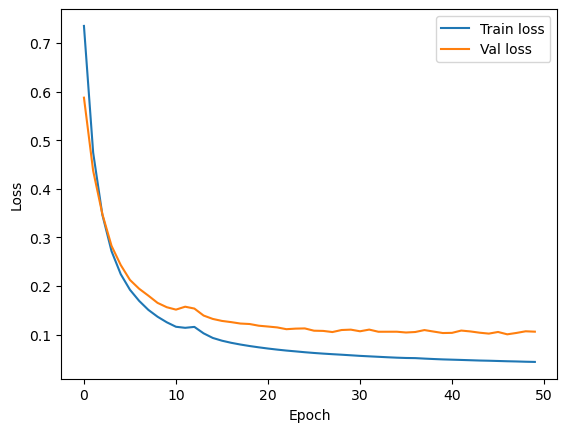

In [8]:

# ---------------------------------------------
# 5) TRAINING & EVALUATION LOOP
# ---------------------------------------------
num_epochs = 50
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AttentionAutoencoder(input_dim=X.shape[1], latent_dim=latent_dim)
model.to(device)

# Use BCEWithLogitsLoss with the computed pos_weight.
# pos_weight should be of shape (input_dim,)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
class_loss_fn = nn.BCEWithLogitsLoss()
alpha = 0.5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_target, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_target = batch_target.to(device)
        batch_y = batch_y.to(device)
        # Forward pass: note that model returns logits.
        x_recon_logits, logits, _ = model(batch_x)
        recon_loss = criterion(x_recon_logits, batch_target)
        class_loss = class_loss_fn(logits, batch_y.unsqueeze(1))
                
        loss = alpha * recon_loss + (1 - alpha) * class_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_x)
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_target, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_target = batch_target.to(device)
            batch_y = batch_y.to(device)
            
            recon_logits, class_logits, _ = model(batch_x)
            recon_loss = criterion(recon_logits, batch_target)
            class_loss = class_loss_fn(class_logits, batch_y.unsqueeze(1))
            
            loss = alpha * recon_loss + (1 - alpha) * class_loss

            val_loss += loss.item() * len(batch_x)
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
print("Training complete.")

# Plot losses
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# save the plot
plt.savefig('../fig/loss_plot_sattn.png')
plt.show()


In [ ]:
# After training, extract the latent representations for the entire dataset.
full_dataset = MutationDataset(X, y_true)
model.eval()
all_latents = []

with torch.no_grad():
    full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
    for batch_x, _, _ in full_loader:
        batch_x = batch_x.to(device)
        z = model.encode(batch_x)
        all_latents.append(z.cpu().numpy())
all_latents = np.concatenate(all_latents, axis=0)  # (num_samples, latent_dim)

# Save latent representations along with patient IDs to CSV.
latent_cols = [f"latent_{i}" for i in range(latent_dim)]
latent_df = pd.DataFrame(all_latents, columns=latent_cols)
latent_df.insert(0, "Patient", patient_ids)
latent_df.to_csv("../data/latent_representations_sattn.csv", index=False)
print("Saved latent representations to 'latent_representations.csv'.")


Saved latent representations to 'latent_representations.csv'.


Latent shape: (23541, 128)


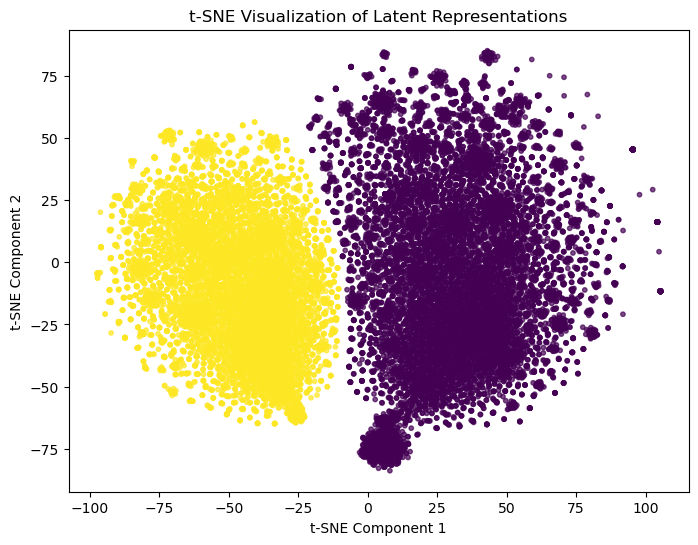

In [10]:
# ---------------------------------------------
# 6) VISUALIZE LATENT REPRESENTATIONS WITH t-SNE
# ---------------------------------------------
model.eval()
latent_list = []
labels_list = []
with torch.no_grad():
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    for batch_x, _, y_label in loader:
        batch_x = batch_x.to(device)
        z = model.encode(batch_x)
        latent_list.append(z.cpu().numpy())
        labels_list.append(y_label.numpy())
        
latent_all = np.concatenate(latent_list, axis=0)
labels_all = np.concatenate(labels_list, axis=0)
print("Latent shape:", latent_all.shape)

# Use t-SNE to reduce latent dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_all)

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_all, cmap='viridis', s=10, alpha=0.7)
plt.title("t-SNE Visualization of Latent Representations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# save plot
plt.savefig("../fig/latent_tsne_sattn.png")
plt.show()
